In [3]:
# data analysis stack
import numpy as np
import pandas as pd

# data visualization stack
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('whitegrid')

# miscellaneous
import warnings
warnings.filterwarnings("ignore")
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

# deep learning stack
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing import image
from tensorflow.keras import backend as K 
import tensorflow.keras.applications.mobilenet_v2 as mb_v2
import tensorflow as tf

### Functions

In [4]:
K.clear_session()

In [5]:
def load_image(image_path):
    """
    loads an input image into PIL format of size 224 X 224
    """
    img = image.load_img(
        path=image_path,
        target_size=(224,224)
    )
    return img

In [6]:
def batch_image(loaded_image):
    """
    converts a loaded image to a batch
    """
    img_array = image.img_to_array(loaded_image)
    img_batch = np.array([img_array])
    
    return img_batch

In [7]:
def preprocess_image(batched_image):
    """
    preprocesses a batch image to make suitable for mobilenet_v2
    """
    processed_img = preprocess_input(batched_image)
    
    return processed_img

In [8]:
def show_preprocess_image(image_path):
    """
    Shows loaded image given an image path, and
    preprocesses it to make suitable for mobilenet_v2.
    """
    # Load resized image
    loaded_img = load_image(image_path)

    # Display image
    plt.figure(figsize=(3, 3), dpi=100)
    plt.imshow(loaded_img)

    # Create batched image
    batch_img = batch_image(loaded_img)

    # Preprocess image
    processed_img = preprocess_image(batch_img)

    return processed_img


In [9]:
def image_class_prediction(model, preprocessed_image):
    """
    Spits out the top-5 predictions of a given model with a proprocessed image.
    """
    model_prediction = model.predict(preprocessed_image, verbose=0)
    decoded_prediction = mb_v2.decode_predictions(model_prediction, top=5)[0]
    data = {
        "image_class": [_[1] for _ in decoded_prediction],
        "probability": [_[2] for _ in decoded_prediction],
    }
    df = pd.DataFrame(data=data)
    return df

### Model

In [10]:
from tensorflow.keras.applications.mobilenet_v2 import (
    MobileNetV2,
    preprocess_input,
    decode_predictions
)

**instantiate model**

In [11]:
pretrained_model = MobileNetV2(
    weights='imagenet'
)

14536120/14536120 [==============================] - 0s 0us/step


In [12]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [13]:
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [14]:
CLASSES = os.listdir('/content/gdrive/MyDrive/project/spiced_deep/train')

In [15]:
print(CLASSES)

['spectacles', 'bananas', 'cellphones', 'cups']


## Evaluate Model

Class 1: Bananas

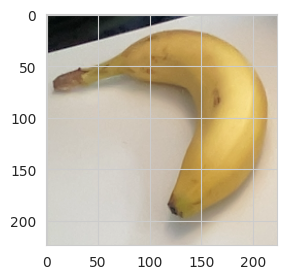

In [16]:
# Show and preprocess an image
banana_image = show_preprocess_image('/content/gdrive/MyDrive/project/spiced_deep/train' + "/bananas/10-01-49-509165.png")

In [17]:
# Class prediction
image_class_prediction(pretrained_model, banana_image)

35363/35363 [==============================] - 0s 0us/step


,image_class,probability
0,banana,0.957936
1,butternut_squash,0.005088
2,bolete,0.004637
3,slug,0.001708
4,hook,0.001672


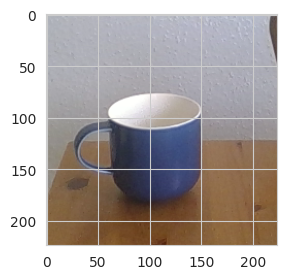

In [18]:
cup_image = show_preprocess_image('/content/gdrive/MyDrive/project/spiced_deep/train' + "/cups/19-38-56-844779.png")

In [19]:
image_class_prediction(pretrained_model, cup_image)

,image_class,probability
0,coffee_mug,0.805118
1,cup,0.141367
2,pitcher,0.007458
3,measuring_cup,0.003333
4,teapot,0.002576


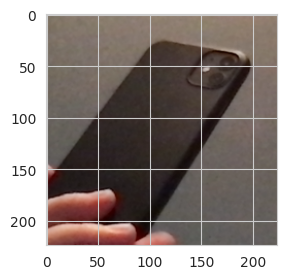

In [20]:
phone_image = show_preprocess_image('/content/gdrive/MyDrive/project/spiced_deep/train' + "/cellphones/07-57-23-024803.png")

In [21]:
image_class_prediction(pretrained_model, phone_image)

,image_class,probability
0,wallet,0.317444
1,remote_control,0.113729
2,switch,0.072861
3,loudspeaker,0.032871
4,cleaver,0.032366


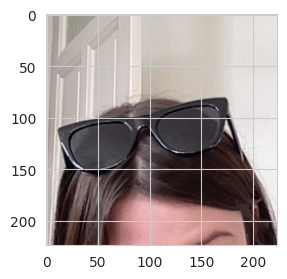

In [22]:
spectacle_image = show_preprocess_image('/content/gdrive/MyDrive/project/spiced_deep/train' + "/spectacles/18-16-10-476908.png")

In [23]:
image_class_prediction(pretrained_model, spectacle_image)

,image_class,probability
0,sunglasses,0.735653
1,sunglass,0.203167
2,purse,0.002228
3,loupe,0.001913
4,bathing_cap,0.001421


## Load our data

In [24]:
# instantiate image data generator
data_gen = image.ImageDataGenerator(
    # preprocessing function for all images
    preprocessing_function=preprocess_input
)

In [25]:
# generate batches of x and y arrays from directory
train_data_gen = data_gen.flow_from_directory(
        directory='/content/gdrive/MyDrive/project/spiced_deep/train',
        class_mode="categorical",
        classes=CLASSES,
        batch_size=400,
        target_size=(224,224)
)

Found 400 images belonging to 4 classes.


In [26]:
# generate batches of x and y arrays from directory
test_data_gen = data_gen.flow_from_directory(
        directory='/content/gdrive/MyDrive/project/spiced_deep/test',
        class_mode="categorical",
        classes=CLASSES,
        batch_size = 40,
        target_size=(224, 224)
)

Found 40 images belonging to 4 classes.


In [27]:
# load in all images at once
xtrain, ytrain = next(train_data_gen)
xtrain.shape, ytrain.shape


((400, 224, 224, 3), (400, 4))

In [28]:
#load all test images
xtest, ytest = next(test_data_gen)
xtest.shape, ytest.shape

((40, 224, 224, 3), (40, 4))

## Model Build

In [29]:
# define base model
BASE_MODEL = MobileNetV2(
    weights='imagenet', 
    alpha=1.0,          # controls number of overall weights
    include_top=False,  # removal of final dense layers
    pooling='avg',      # average pooling to last convolutional layer's ouput
    input_shape=(224,224,3) # ignored if input tensor is provided
)


9406464/9406464 [==============================] - 0s 0us/step


In [30]:
# Freeze base model
BASE_MODEL.trainable = False

In [31]:
# base model summary
BASE_MODEL.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

In [32]:
def HyperModel(hyperparameters):
    '''
    creates a hypermodel by stacking dense layers on top of base model. 
    Hyperparameters to be tuned: 
    1. number of neurons in the first dense layer,
    2. initial learning rate of the optimizer
    Args:
    hyperparameters - Keras tuner object
    '''
    # initialize the Sequential API to stack the layers
    model = keras.Sequential()
    
    # convolutional base 
    model.add(BASE_MODEL)
    
    # number of neurons in first dense layer
    hp_units = hyperparameters.Choice(
        'units', 
        values=[400,200,100]
    )
    # first dense layer
    model.add(
        keras.layers.Dense(
            units=hp_units, 
            activation='relu'
        )
    )
    # dropout 
    model.add(
        keras.layers.Dropout(
            rate=0.5
        )
    )
    # output layer with softmax activation function
    model.add(
        keras.layers.Dense(
            len(CLASSES),
            activation='softmax'
        )
    )
    # learning rate for the optimizer
    hp_learning_rate = hyperparameters.Choice(
        'learning_rate', 
        values=[1e-2, 1e-3, 1e-4]
    )
    # compile model
    model.compile(
        optimizer=keras.optimizers.Adam(
            learning_rate=hp_learning_rate
        ),
        loss=keras.losses.categorical_crossentropy,
        metrics=[keras.metrics.categorical_accuracy]
    )

    return model

In [33]:
pip install keras_tuner

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 4.7 MB/s eta 0:00:00


In [34]:
import keras_tuner as kt

In [35]:
# instantiate gridsearch
tuner = kt.GridSearch(
    hypermodel=HyperModel,
    objective='val_categorical_accuracy'
)

In [36]:
# hypertuning settings summary
tuner.search_space_summary() 

Search space summary
Default search space size: 2
units (Choice)
{'default': 400, 'conditions': [], 'values': [400, 200, 100], 'ordered': True}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


In [37]:

stop_early = keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=10
)

In [38]:
tuner.search(
    xtrain, 
    ytrain,
    epochs=25,
    validation_split=0.2,
    callbacks=[stop_early]
)

Trial 9 Complete [00h 00m 27s]
val_categorical_accuracy: 0.949999988079071

Best val_categorical_accuracy So Far: 1.0
Total elapsed time: 00h 04m 17s


In [39]:
best_hp = tuner.get_best_hyperparameters(1)[0]

In [40]:
best_hp.get('units')


400

In [41]:
best_hp.get('learning_rate')

0.01

In [42]:
h_model = tuner.hypermodel.build(best_hp)
h_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 1280)             2257984   
 ional)                                                          
                                                                 
 dense_2 (Dense)             (None, 400)               512400    
                                                                 
 dropout_1 (Dropout)         (None, 400)               0         
                                                                 
 dense_3 (Dense)             (None, 4)                 1604      
                                                                 
Total params: 2,771,988
Trainable params: 514,004
Non-trainable params: 2,257,984
_________________________________________________________________


### Train and save the model

In [43]:
h_model.fit(
    xtrain,
    ytrain,
    epochs=100,
    batch_size=64,
    callbacks=[stop_early],
    validation_split=0.2
)

Epoch 1/100
5/5 [==============================] - 5s 341ms/step - loss: 5.5760 - categorical_accuracy: 0.5781 - val_loss: 0.6147 - val_categorical_accuracy: 0.9000
Epoch 2/100
5/5 [==============================] - 1s 118ms/step - loss: 1.3183 - categorical_accuracy: 0.8844 - val_loss: 0.4951 - val_categorical_accuracy: 0.9625
Epoch 3/100
5/5 [==============================] - 1s 135ms/step - loss: 0.3359 - categorical_accuracy: 0.9344 - val_loss: 0.9589 - val_categorical_accuracy: 0.8875
Epoch 4/100
5/5 [==============================] - 1s 144ms/step - loss: 0.4486 - categorical_accuracy: 0.9438 - val_loss: 0.0840 - val_categorical_accuracy: 0.9625
Epoch 5/100
5/5 [==============================] - 1s 177ms/step - loss: 0.1688 - categorical_accuracy: 0.9812 - val_loss: 0.3743 - val_categorical_accuracy: 0.9500
Epoch 6/100
5/5 [==============================] - 1s 182ms/step - loss: 0.1137 - categorical_accuracy: 0.9812 - val_loss: 0.2075 - val_categorical_accuracy: 0.9750
Epoch 7/10

In [44]:
h_model.save("model_weekly_project_fit.h5")

In [45]:
h_model_fit = keras.models.load_model("model_weekly_project_fit.h5")
h_model_fit.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 1280)             2257984   
 ional)                                                          
                                                                 
 dense_2 (Dense)             (None, 400)               512400    
                                                                 
 dropout_1 (Dropout)         (None, 400)               0         
                                                                 
 dense_3 (Dense)             (None, 4)                 1604      
                                                                 
Total params: 2,771,988
Trainable params: 514,004
Non-trainable params: 2,257,984
_________________________________________________________________


### Model Evaluation

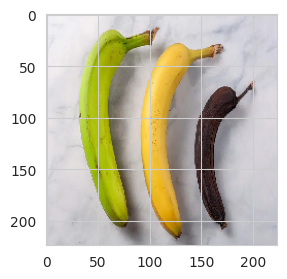

In [52]:
test_image = show_preprocess_image('/content/gdrive/MyDrive/project/spiced_deep/test' + "/bananas/bananas_09.jpg")

In [53]:
def image_predict(preprocessed_image, model):
    """
    Returns class probabilities for a given image,
    based on the model obtained via transfer learning
    """
    probabilities = model.predict(
        preprocessed_image,
        verbose=0,
    )
    probabilities = np.round(probabilities, 6)[0]
    class_probabilities = dict(zip(CLASSES, probabilities))

    return class_probabilities

In [54]:
# Predict image class
image_predict(test_image, h_model)

{'spectacles': 0.0, 'bananas': 1.0, 'cellphones': 0.0, 'cups': 0.0}

In [55]:
def transfer_learning_prediction(model, x, y):
    """
    Returns dataframe with class probabilities and true class label
    """
    # Prediction dataframe along with true class
    df_pred = pd.DataFrame(
        columns=CLASSES,
        data=np.round(model.predict(x, verbose=0), 6),
    )

    # Convert vectorized classes into strings
    df_pred["class"] = [
        "".join([i * j for (i, j) in zip(CLASSES, vector)]) for vector in y.astype(int)
    ]

    return df_pred

In [56]:
test_prediction = transfer_learning_prediction(
    h_model,
    xtest,
    ytest,
)

test_prediction

,spectacles,bananas,cellphones,cups,class
0,1.000000,0.000000,0.000000,0.000000,spectacles
1,0.000000,0.000000,0.000000,1.000000,cups
2,0.694815,0.000000,0.000005,0.305180,cellphones
3,0.000000,0.000000,1.000000,0.000000,cellphones
4,0.000000,1.000000,0.000000,0.000000,bananas
5,1.000000,0.000000,0.000000,0.000000,spectacles
6,1.000000,0.000000,0.000000,0.000000,spectacles
7,0.000000,1.000000,0.000000,0.000000,bananas
8,0.000000,0.000000,0.000000,1.000000,cups
9,0.000000,0.000000,1.000000,0.000000,cellphones


Rakib accuracy

In [57]:
# Show mean probabilities
grouped_df = transfer_learning_prediction(h_model_fit, xtest, ytest).groupby("class").mean()
grouped_df.sort_index(axis=1, inplace=True)
grouped_df

,bananas,cellphones,cups,spectacles
class,,,,
bananas,1.000000,0.000000,0.000000,0.000000
cellphones,0.000012,0.854237,0.030652,0.115099
cups,0.000002,0.000000,0.999747,0.000250
spectacles,0.000001,0.040401,0.000234,0.959363


In [58]:
def accuracy_score(model, x, y):
    """
    Spits out multi-class accuracy.
    """
    grouped_df = transfer_learning_prediction(model, x, y).groupby("class").sum()

    grouped_df.sort_index(axis=1, inplace=True)

    accuracy_score = np.trace(grouped_df) / np.array(grouped_df).sum()
    accuracy_score = round(accuracy_score, 6)

    return accuracy_score

In [63]:
accuracy_score(h_model, xtest, ytest)

0.953337

model.evaluate

In [62]:
test_loss, test_acc = h_model.evaluate(xtest, ytest)
print('test loss ', test_loss, '\ntest acc ', test_acc)

2/2 [==============================] - 0s 27ms/step - loss: 0.3336 - categorical_accuracy: 0.9750
test loss  0.3336258828639984 
test acc  0.9750000238418579
